In [2]:
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
hdul = fits.open("../cosmos/cosmosall_u2k_v2_30nov2023.fits")
FLAGS = fits.open("../cosmos/HSCJ_cosmosAll_u2k_FLAGS_beta0pt9.fits")
#this one is big and annoying to load...
zout = np.genfromtxt("../cosmos/HSCJ_COSMOS_u2k_v2.9.zout",dtype=str)


In [4]:
data = hdul[1].data

## FLAGS

In [5]:
galaxy_flag = FLAGS[1].data.field("use_hiz")+FLAGS[1].data.field("use_galaxy")
#fairly sure all use_hiz are part of uze_galaxy, but to be sure....

In [6]:
#relevent fluxes

fluxy = data.field("y_psfFlux")
fluxu = data.field("u_psfFlux")
fluxg = data.field("g_psfFlux")
fluxr = data.field("r_psfFlux")

#relevant z_photo info

z_spec = np.array(zout[:,2],dtype=float)
z_spec_flag = zout[:,3]

nfilt = np.array(zout[:,4],dtype=int)

z_phot = np.array(zout[:,5],dtype=float) #11 (Median) is better? 7 is best fit or spec-z if available
z_phot_chi2 = np.array(zout[:,6],dtype=float)

#

In [7]:
# y_cut

In [8]:
# y_cut
in_AB = (-2.5*log10(fluxy) + 27) < 25.3

#ugr cut
ugr = (fluxu>0)*(fluxg>0)*(fluxr>0)


#z_cut
z_cut = (z_phot>2.1)*(z_phot<3.5)

z_background = (z_phot>2.5)
#filters cut
filter_cut = (nfilt>10)

#r_cut
r_AB = (-2.5*log10(fluxr) + 27)

r_low = (r_AB>24.2)

r_high = (r_AB<24.8)



/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


In [87]:
#Foreground sample:

bool_foreground = galaxy_flag*z_cut*in_AB*filter_cut*~z_background
np.sum(bool_foreground)

29870

In [88]:
#high
bool_high = galaxy_flag*z_cut*in_AB*filter_cut*z_background*r_low*r_high
np.sum(bool_high)

5227

In [89]:
#low
bool_low = galaxy_flag*z_cut*in_AB*filter_cut*z_background*(~r_low)
np.sum(bool_low)

1433

In [90]:
#show on sky...
RA = data.field("RA")
DEC = data.field("DEC")

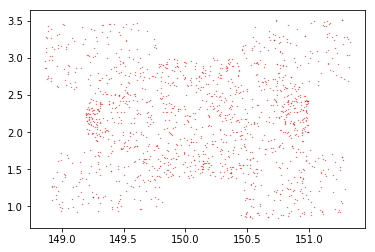

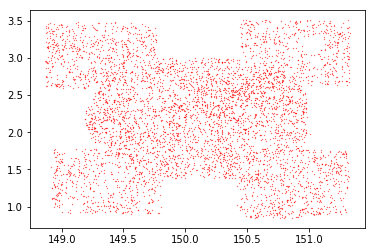

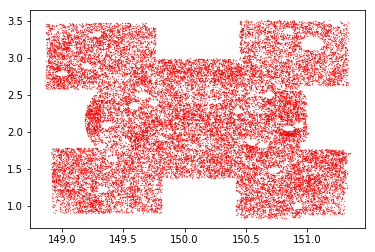

In [91]:
plt.plot(RA[bool_low],DEC[bool_low],"r.",markersize=0.5)
show()
plt.plot(RA[bool_high],DEC[bool_high],"r.",markersize=0.5)
show()
plt.plot(RA[bool_foreground],DEC[bool_foreground],"r.",markersize=0.5)
show()

In [92]:
data.field("RA")

array([149.46674, 149.42642, 149.4568 , ..., 151.01282, 151.07901,
       151.07861], dtype=float32)

In [93]:
#define pointings, from KG

In [94]:
import numpy as np
import copy
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import ascii
from astropy import wcs
from astropy.io import fits
from astropy.table import QTable, Table, Column,vstack

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc('mathtext',fontset='stixsans')
#matplotlib.rc_file(\"../../templates/matplotlibrc\")
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
# Astropy Regions (but standalone package installed with pip)
import regions

In [95]:
def pfs_vertices(ctr_coord,pa=0):
    # Given a field center (SkyCoord object), return the 6 vertices of a Subaru PFS field. Optional PA is in degrees
    d = 41.4*u.arcmin 
    vertices=[]
    for i in range(6):
        angularoffset = np.pi / 3 * i *u.radian + pa*u.deg
        vertices.append(ctr_coord.directional_offset_by(angularoffset,d))
    return SkyCoord(vertices)

In [96]:
ge_fields_in = ascii.read('pfs_ge_centers.txt')

fields   = ge_fields_in['fieldname']
subfield = ge_fields_in['subfieldno']
ra_field = ge_fields_in['ra']
dec_field= ge_fields_in['dec']

ctr_coords = SkyCoord(ra=ra_field*u.deg, dec=dec_field*u.deg, frame='icrs')

In [97]:
fieldstr = 'COSMOS'
getfields = fields==fieldstr
ctrs_here = ctr_coords[getfields]
n_pointings=np.sum(getfields)

# Compute a very rough center position for these pointings, as the average of the pointing centers
rough_ctr = SkyCoord(ra=np.mean(ctrs_here.ra.to(u.deg)), dec=np.mean(ctrs_here.dec.to(u.deg)), frame='icrs')

print('Rough center for '+fieldstr+': '+rough_ctr.ra.to_string(u.hour)+rough_ctr.dec.to_string(u.deg,alwayssign=True))

Rough center for COSMOS: 10h00m25.6158s+2d06m28.8659s


In [98]:
wcstmp = wcs.WCS(naxis=2)
wcstmp.wcs.crpix=[1,1]
wcstmp.wcs.crval=[148.547008, 0.662545] # eyeballed off hscMap
wcstmp.wcs.cdelt=[0.001666667, 0.00166667]
wcstmp.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wcstmp.wcs.radesys='ICRS'
wcstmp.wcs.equinox=2000.00

ctr1 = ctr_coords[9]

/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 

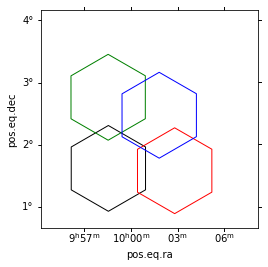

In [99]:
all_regions = []

# Des
pa_list = [0,0,0,0]

# This creates the Regions (i.e. list of regions)
for tmpcoord,pa_tmp in zip(ctr_coords[getfields],pa_list):
    all_regions.append(regions.PolygonSkyRegion(vertices=pfs_vertices(tmpcoord,pa=pa_tmp)))

# This is the composite region of all pointings
for ii in range(n_pointings-1):
    if ii == 0:
        comb_region = all_regions[0]
    comb_region = comb_region | all_regions[ii+1]

pix_reg_allcosmos = comb_region.to_pixel(wcstmp)

colorlist=['black','green','red','blue']

ax=plt.subplot(projection=wcstmp)
ax.set_xlim(0,2100)
ax.set_ylim(0,2100)
for reg_tmp,colortmp in zip(all_regions,colorlist):
    pix_reg_tmp = reg_tmp.to_pixel(wcstmp)
    ax.add_artist(pix_reg_tmp.as_artist(color=colortmp))
ax.set_aspect('equal')

In [100]:
from shapely.geometry import Point


In [101]:
region = all_regions[0]

In [102]:
for nn,region in enumerate(all_regions):
    print("Cosmos " + str(nn))
    for targetclass in [bool_low,bool_high, bool_foreground]:
        coords = SkyCoord(ra = RA[targetclass]*u.degree, dec = DEC[targetclass]*u.degree, frame='icrs')
        print( np.sum(region.contains(coords,wcstmp)))
        

Cosmos 0
315
1066
6110
Cosmos 1
302
1164
6129
Cosmos 2
320
1070
7065
Cosmos 3
423
1537
7280


In [103]:
region.contains(coords,wcstmp)

array([False, False, False, ..., False, False, False])

In [104]:
RA[targetclass][region.contains(coords,wcstmp)]

array([150.71588, 150.73969, 150.73947, ..., 150.99458, 150.99219,
       150.99887], dtype=float32)

/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 

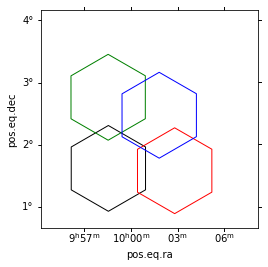

In [105]:
for ii in range(n_pointings-1):
    if ii == 0:
        comb_region = all_regions[0]
    comb_region = comb_region | all_regions[ii+1]

pix_reg_allcosmos = comb_region.to_pixel(wcstmp)

colorlist=['black','green','red','blue']

ax=plt.subplot(projection=wcstmp)
ax.set_xlim(0,2100)
ax.set_ylim(0,2100)
for reg_tmp,colortmp in zip(all_regions,colorlist):
    pix_reg_tmp = reg_tmp.to_pixel(wcstmp)
    ax.add_artist(pix_reg_tmp.as_artist(color=colortmp))
ax.set_aspect('equal')

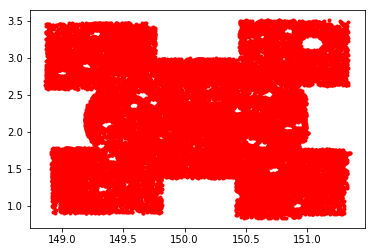

In [106]:
plot(RA[targetclass],DEC[targetclass],"r.")


In [107]:
tf_coords = SkyCoord(ra = RA[targetclass][region.contains(coords,wcstmp)]*u.deg, dec=DEC[targetclass][region.contains(coords,wcstmp)]*u.deg, frame='icrs')
xqso, yqso = wcstmp.world_to_pixel(tf_coords)


/global/homes/b/bhorowit/.conda/envs/nersc-all2/lib/python3.6/site-packages/matplotlib/patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


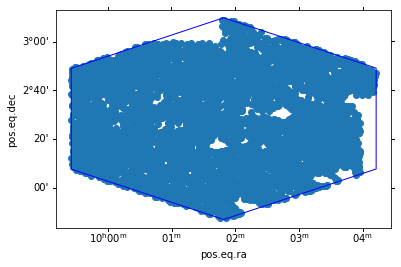

In [108]:
ax=plt.subplot(projection=wcstmp)
pix_reg_tmp = reg_tmp.to_pixel(wcstmp)
ax.add_artist(pix_reg_tmp.as_artist(color=colortmp))
ax.scatter(xqso, yqso)
